<div style = "border-radius:10px; color: #3ABF5A; background-color: #3A3A3A">
    <h1 style  = "padding: 8px;">Swimming Pool Detection using YOLOv5</h1>
</div>

For some tasks, there are __pretrained models__ that are already trained on huge datasets using a vast computing resource. Trying to a build a model from scratch for such tasks may be reinventing the wheel. We can simply take the pretrained model and train it on our specific data for some time and get very good accuracy withing a few hours, which would have taken us weeks or even months if we had done all the model building and training from scratch.

[YOLOv5](https://github.com/ultralytics/yolov5) is a really great open-source object detection model. Through __transfer-learning__, this model can be easily trained to a custom dataset for detecting the feature of our interest.

This tutorial will guide us on using this model for swimming pool  detection in satellite images.

__*I strongly encourage you to follow the data preparation steps yourself.
You will need to do this to access the trained data programmatrically using roboflow.
However, if you would like to use already preapred data, you can find it
at  [Roboflow dataset](https://universe.roboflow.com/pratik-dhungana-pvv5d/swimmingpooldataset/dataset/1) and 
you will need to sign in or create a new account with roboflow to access the dataset. Then skip the [step 2.2](#2.2)*__


First, we will see how to prepare the training data then we will train, test and deploy the model.

- [1 - Data Preparation](#1)
  - [1.1 Getting satellite image](#1.1)
  - [1.2 Clipping satellite Image](#1.2)
  - [1.3 Annotating Images](#1.3)
- [2 - Model Installation and Set up](#2)
- [3 - Train the model](#3)
- [4 - Testing the model](#4)
- [5 - Deploying the model](#5)

<a name = '1'></a>
## 1 - Data Preparation
For our swimming pool detection, we will need some satellite images. As swimming pools are not easily identifiable in moderate-resolution images such as Landsat, we will use high-resolution images from base maps. We will use ArcMap, a desktop GIS software to save the satellite images. This will require some manual work.

<a name = '1.1'></a>
## 1.1 Getting Satellite Images

1. Open ArcMap. From the drop-down of Add Data, select __Add Basemap__ and choose the __Imagery__.
<img style = "width: 50%;" src = './Notebook jpgs/addBasemap.PNG'><br>

2. Use the __Go to XY__ tool. From the dropdown, change the unit to __Meters__ .
<img style = "width: 50%;" src = './Notebook jpgs/gotoXY.PNG'><br>

For __longitude__, enter the value __-10962575__, and for __latitude__ enter value __3456760__.
This will zoom to a portion of __San Antenio, Texas__.

3. From the main menu, go to __View__ and to the __Layout View__.
<img src = './Notebook jpgs/GotoLayout.PNG'><br>

4. Now, activate the __Layout__ tools by right cleaning on the gray area above the display port, then checking the __Layout__ tool.
<img src = './Notebook jpgs/activateLayoutTool.PNG'><br>

5. From the __Layout__ tool, click on __Change Layout__. Then choose __ISO A0 Landscape__, then click __finish__ and wait for the changes to take effect.
<img src = './Notebook jpgs/changeLayout.PNG'><br>

6. Now, click on the map area. It will show a bounding box (map frame), strech it's boundaries beyond the outline of the paper.
<figure>
    <img style = 'width: 45%; display: inline' src = './Notebook jpgs/before.PNG'>
    <figcaption>Before stretching the map frame</figcaption>
</figure>
<br>
<figure>
    <img style = 'width: 45%; display: inline' src = './Notebook jpgs/after.PNG'><br>
    <figcaption>After stretching the map frame</figcaption>
</figure>

You may want to change the scale at which the map is rendered. From the __Standard Toolbar__ change the scale to 1:2100 or higher.

<img src = './Notebook jpgs/scale.PNG'><br>

Now it's time to save the map. We will export the map to jpeg format. It definitely distorts the radiometric properties of the images, when saving a satellite image for future analysis that might depend on spectral signature it is not advisable. But for our purpose here, as we can still identify swimming pools from resampled images, we are good to go.

7. From the main menu, go to __File__ and click __Export Map__ button. Save as type __JPEG__ with the __resolution__ of __150 dpi__ and save at an appropriate location.
<img src = './Notebook jpgs/saveJPEG.PNG'><br>





<a name = '1.2'></a>
## 1.2 Clipping Satellite Images

For object detection, we will need multiple smaller images. In each image we will annotate the bounding box of every swimming pool we will see for training.
So, we need to clip the satellite image. For this we will use [Python](https://www.python.org/downloads/).
First make sure you have python 3.x installed on your computer.

Go to the folder where you saved the image from step 1.1, then on the address bar, type __cmd__ then hit __enter__ to open a __command Prompt__ at that directory. Alternatively, we can open the command prompt first and change the directory to that location by running __cd  '\<full path to the folder\>'__

We will also need to install `Pillow` package for reading and writing images and `numpy` for clipping images. When in that directory, run following commands to install these packages. Be sure to remove the dollar sign ('$') if running directly in the command line.

In [ ]:
$ pip install numpy

In [ ]:
$ pip install Pillow

After the packages are installed, we will need to load required packages for image clipping.

### Setting up

In [ ]:
import numpy as np
from PIL import Image
import os

If we are running the code in command line, change the directory to the folder containing the __LargeImage.jpg__ .

In [ ]:
os.chdir('/content/')

### Read image

In [ ]:
image = Image.open('LargeImage.jpg')

### Convert image to numpy array

In [ ]:
im = np.asarray(image)

### Clipping Images
Output image will be of shape (M, N). This will split into x*x images of size (M,N) and a few corner images may also be produced of remainder size.
If we want the output be of certain size then provide then set M and N to those values.

In [ ]:
# Get shape and size of each output tile
x = 10
M = im.shape[0]//x
N = im.shape[1]//x

tiles = [im[x:x+M,y:y+N,:] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]


### Save tiles as jpg

In [9]:
for idx, tile in enumerate(tiles):
  tileImage = Image.fromarray(tile)
  tileImage.save(f'tile_{idx}.jpg')


### Download images from colab to local disk
This part only applies if we use colab to split the image into tiles which we will upload to roboflow for annotation. Otherwise, our tiles are already saved on our local disk and we are ready to move to image annotation part. 

In [ ]:
from google.colab import files
files.download('/content')

<a name = '1.3'></a>
## 1.3 Annotating Images
We will use [roboflow](https://roboflow.com/), which is a great tool for annotating images or videos, to annotate the images with bounding box. First we have to sign up at [roboflow](https://roboflow.com/), which can be done with any email or github account. We can create a new workspace as a hobbies type and give any name.

We can skip inviting other people and create a public workspace. Create on __new project__ and __Explore Solo__ and we are detecting __Swimming pools__. For license type, we can choose any of the options.

Now, we can either drag-and-drop images or add files or folder. After it finishes uploading images, click on __save and continue__ on the top-right corner.
<img src = './Notebook jpgs/dragAndDropImages.PNG'><br>

Next step is to assign different images to different person. But as there is only one person in this workspace, simply assign images to that account.

Now, for the actual annotation, click on the first image and start drawing a rectanglular bounding box around the image. After drawing one polygon hit enter to save it. We can draw multiple polygons if there are multiple swimming pools or not draw any if there is no swimming pool in the image.
<img src = './Notebook jpgs/drawBoundaries.PNG'><br>

After finishing the __Annotation__, go to back. It will show how many images are labelled or unlabelled and ask to __add the labelled images to dataset__. Click there. Keep 70% for training and 15% each for validation and testing. Click on __Add Images__.

Now click on __Generate New Version__ . Keep everything default. Go to number 5 __Generate__.
<img src = './Notebook jpgs/Generate.PNG'><br>

It will generate a version of data. Go to __Export__, and in the __format__, choose __YOLOv5 PyTorch__ annd click on __Continue__. This will generate a __download code__ that can be run in jupyter notebook or colab. Copy this code, we will need this to download our dataset, and also pay attention to the warning.
<img src = './Notebook jpgs/ChangeModelVersion.PNG'><br>

<a name = '2'></a>
## 2 - Model Installation and setup

<a name = '2.1'></a>
## 2.1 Installing yolov5
We can clone the __yolov5__ github repository to obtain the pretrained model. We will need to install some dependencies for running this model. Also, we will install __roboflow__, which we will need to obtain the data using the __download code__ copied at the end of the previous step.

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

<a name = '2.2'></a>
## 2.2 Load Data from roboflow
In the cell below, paste the __download code__ copied from roboflow to obtain the data we prepared at the end of the step [1.3](#1.3)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="<personal_key>") # Replace
project = rf.workspace("<workspace_name>").project("<project_name>") # Replace
dataset = project.version(2).download("yolov8")

In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

<a name = '3'></a>
## 3 - Train the model
(__Already have the best.pt ? click [here](#5) to go to the detection section__.)
Run the following cell to train the model.


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

<a name = '4'></a>
## 4 - Detect swimming pools on test image
In the following cell make sure the location of __best.pt__ is correct and the path of folder containing test images is also correct. This exact same code will also be used for detecting in the future, but we will need to change the location of __best.pt__ and folder containing images.

The parameter `conf` is set to 0.2. Setting it low will detect more swimming pools but will also detect other things as swimming pool meaning it will increase the __comission error__, and setting it high will detect fewer swimiming pool meaning it will increase the __omission error__. We can play around with this value to see what works best.

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.2 --source /content/datasets/SwimmingPoolDataset-1/test/images

Now, let's visually inspect how well the model did.

In [ ]:
from matplotlib import pyplot as plt
from numpy import array
from PIL import Image

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    image = Image.open(imageName)
    plt.imshow(array(image))
    plt.show()
    print("\n")

It seems the model is doing preety good job. As the storage of this colab session is temporary, if we want to use this model in the future without training it again, we will need to save the model weights. Run the following code to download the best weights.

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a name = '5'></a>
## 5 - Deploying the model

Now we have the weights saved, we have no need to train the model if we want to simply use the model for detecting swimming pools. For this we will need to prepare the image on which we want to detect the swimming pool by following the method described in [section 1](#1).


If we want to use colab for detection, we will have to upload the images and weights to the collab session storage. Then, for the following cells, the location of best.pt,location of image on which we want to run the detection need to be changed. By running the cell below with appropriate parameters we can detect the images

In [12]:
!python detect.py --weights /content/best.pt --img 640 --conf 0.2 --source /content/sample_data/exp

Now run the following cell after changing the location of output images, to visually inspect them.

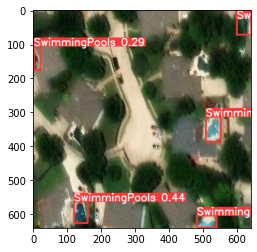

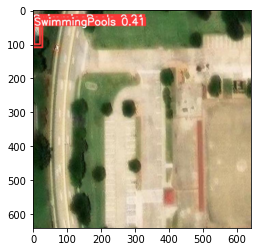

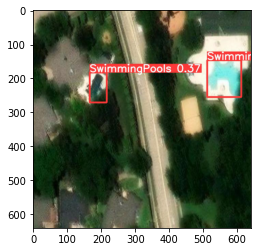

In [17]:
from matplotlib import pyplot as plt
from numpy import array
from PIL import Image

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    image = Image.open(imageName)
    plt.imshow(array(image))
    plt.show()
    print("\n")

__Congratulations__!! Now you know:
* how to prepare data for object detection,
* how to use a transfer learning and
* how to deploy a trained model.

Good luck on your learning journey.